In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import pandas as pd
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from utils import get_df, analyze_budget_consumption, plot_budget_consumption, analyze_bias, plot_bias

In [51]:
path = "ray/synthetic/optimizations/run_and_report_2024-03-26_05-08-13"

In [52]:
%%time
budget_df = analyze_budget_consumption(path)
budget_df

0
1
2
1
1 121 121
20000
1 121 121
20000
1 121 121
CPU times: user 28.2 s, sys: 6.82 s, total: 35.1 s
Wall time: 34.9 s


,destination,num_reports,max_budget_conusmed,avg_budget_consumed,status,baseline,optimization,num_days_per_epoch,num_days_attribution_window
0,1,20000,0.005899,0.005899,OK,ipa,multiepoch,1,30
1,1,40000,0.011798,0.011798,OK,ipa,multiepoch,1,30
2,1,60000,0.017698,0.017698,OK,ipa,multiepoch,1,30
3,1,80000,0.023597,0.023597,OK,ipa,multiepoch,1,30
4,1,100000,0.029496,0.029496,OK,ipa,multiepoch,1,30
...,...,...,...,...,...,...,...,...,...
399995,1,399996,0.006089,0.004159,OK,systemx,multiepoch,1,30
399996,1,399997,0.006089,0.004159,OK,systemx,multiepoch,1,30
399997,1,399998,0.006089,0.004159,OK,systemx,multiepoch,1,30
399998,1,399999,0.006089,0.004159,OK,systemx,multiepoch,1,30


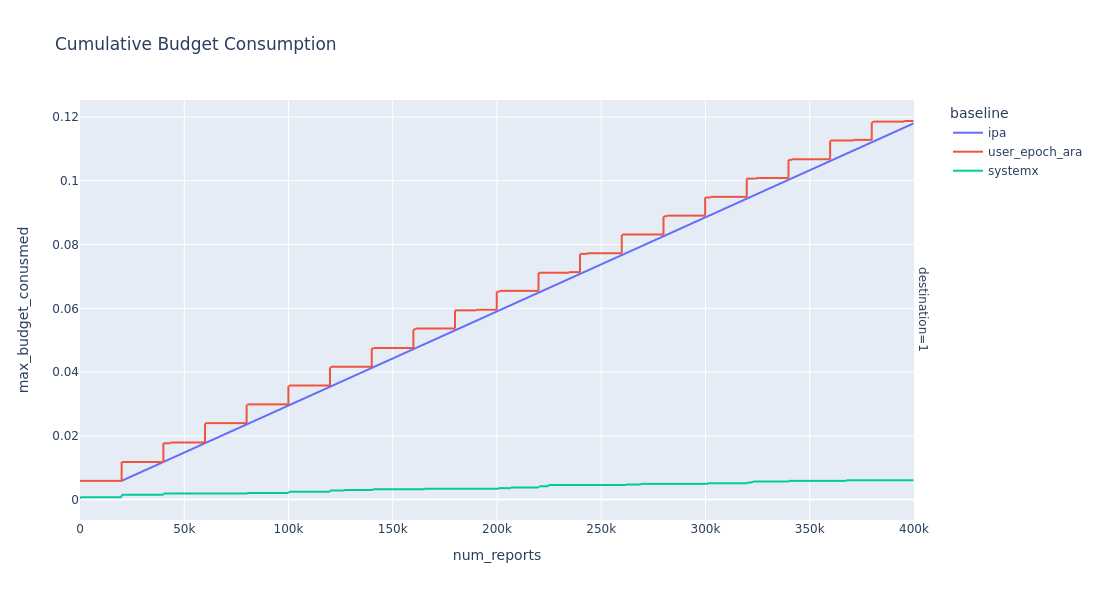

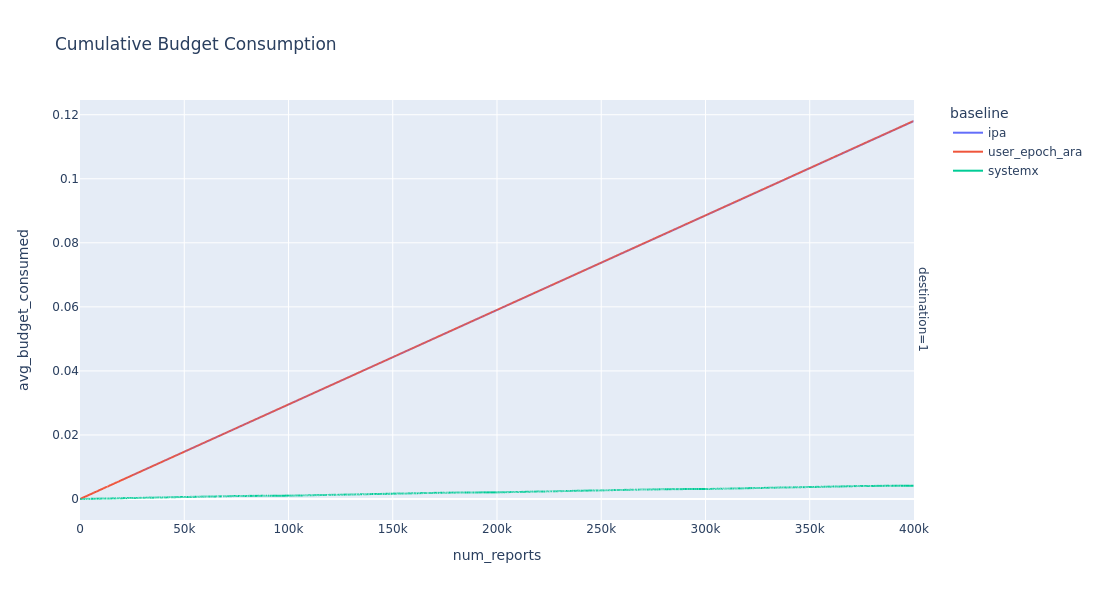

In [53]:
plot_budget_consumption(budget_df)

In [ ]:
bias_df = analyze_bias(path)
plot_bias(bias_df)

In [ ]:
dfs

In [ ]:
import plotly.express as px
from plotly.offline import iplot

dfs["key"] = (
    dfs["baseline"] + "-days_per_epoch=" + dfs["num_days_per_epoch"].astype(str)
)

fig = px.line(
    dfs,
    x="num_reports",
    y="max_budget_conusmed",
    color="baseline",
    title=f"Cumulative Budget Consumption",
    width=1100,
    height=600,
    markers=True,
    facet_row="destination",
)

iplot(fig)

In [ ]:
def get_logs(row):
    logs = row["logs"]["budget"]
    df = pd.DataFrame.from_records(logs, columns=["timestamp", "destination", "user", "epochs_window", "attribution_window", "budget_consumed", "status"])

    records = []
    for destination, destination_df in df.groupby(["destination"]):

        num_users = destination_df["user"].nunique()
        min_epoch = destination_df["epochs_window"].iloc[0][0]
        max_epoch = destination_df["epochs_window"].iloc[-1][1]
        num_epochs = max_epoch - min_epoch + 1



        destination_df["budget_consumed"] = destination_df.groupby(["user"])["budget_consumed"].transform("cumsum")
        destination_df["max_budget_consumed"] = destination_df.groupby(["user"])["budget_consumed"].transform("max") / num_epochs
        destination_df["avg_budget_consumed"] = destination_df.groupby(["user"])["budget_consumed"].transform("mean") / num_epochs

        print(destination_df)
        return

        users = np.zeros(num_users)
        for _, log in destination_df.iterrows():
            user_index = log["user"] if log["user"] != "all_users" else 0
            users[user_index] += log["budget_consumed"]
            # print(log)
            records.append(
                {
                    "destination": destination[0],
                    "num_reports": log["timestamp"],
                    "max_budget_conusmed": np.max(users) / num_epochs,
                    "avg_budget_consumed": np.mean(users) / num_epochs,
                    "status": log["status"],
                    "baseline": row["baseline"],
                    "optimization": row["optimization"],
                    "num_days_per_epoch": row["num_days_per_epoch"],
                    "num_days_attribution_window": row[
                        "num_days_attribution_window"
                    ],
                }
            )
    return pd.DataFrame.from_records(records)

dfs = []
df = get_df(path)
for _, row in df.iterrows():
    dfs.append(get_logs(row))